### Updates
11/1/2020
- added code so users can choose 'EU' as a place
- in progress - adding detailed comments to make code more legible

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The data all comes from the Github repository maintained by Johns Hopkins, https://github.com/CSSEGISandData

In [2]:
# get the data from the Github repository
filepathA = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
filepathB = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
filepathC = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
filepathD = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
filepathF = "https://raw.githubusercontent.com/umpirsky/country-list/master/data/en_US/country.csv"
filepathG = "https://raw.githubusercontent.com/benhowe75/covid_082020/Latest/country_codes_eu.csv"
filepathH = "https://raw.githubusercontent.com/benhowe75/covid_082020/Latest/state_table.csv"

This block gets lists of states and countries for checking entries later.

In [3]:
states = pd.read_csv(filepathA)
statelist = states.loc[:,"Province_State"].unique()         # get list of all states for reference

countries = pd.read_csv(filepathC)
countrylist = countries.loc[:,"Country/Region"].unique()    # get list of all countries for reference

eu = pd.read_csv(filepathG)
eulist = eu.loc[:,'Country'].unique()                       # get list of EU countries for reference
# eulist = eulist[eulist != ['Albania','Montenegro','Serbia','Turkey']]                 

## Definitions

There are two primary categories, either conformed cases or deaths. Since it is unusual and unwise to compare them, users can choose on eor the other.

In [4]:
def get_choice1():
    while True:
        try:
            tipar3 = input("Do you want cases or deaths? Enter '1' for cases or '2' for deaths. ")
            tipar3 = int(tipar3)
            if tipar3 == 1 or tipar3 == 2:
                break
            else:
                print("choose only 1 for cases or 2 for deaths.")
        except ValueError as e:
            print("Error")
    return(tipar3)

This function makes sure that user choices are countries and states in the database. I don't know what was so special about this block but it took me a long time to get it to respond correctly for names not in either list.

This name block continues to give me problems. I fixed it so that US which gets changed to 'Us' is correctly read as 'US'. There is still the isuue of Georgia being both a state and a country. There are others, I'm certain, that use non-standard latin characters, things like é, œ, or ñ. I think the best way to handle these is to keep track of the exceptions and build a dictionary for those cases.

In [5]:
except_dict ={'Us':'US'}

In [6]:
def check_name(b):
    j = 0
    while j < b:
        try:
            string = input("What's the place?").strip()
            string =' '.join(w.capitalize() for w in string.split())
            if string == 'Us':
                string = 'US'
                break              
            if string == 'Eu':
                string = 'EU'
                break                
            elif string in statelist or string in countrylist:
                j += 1
                break
            else:
                print("Pick a better location.")
        except Exception as e:
            print("Error")
    return(string)

I had to add this function as an afterthought to figure out which database to look in for each place.

In [7]:
def get_choice2(name):
    while True:
        try:
            if name in statelist:
                choice2 = 2             # assign 2 if place is a US state       
            elif name in countrylist:
                choice2 = 1             # assign 1 if place is a country
            elif name == 'EU':
                choice2 = 1             # assign 2 if place is EU
            else:
                "Something went wrong."
            break
        except ValueError as e:
            print("Error")
    return(choice2)

This function just gets the right filepath for the given attributes.

In [8]:
def get_data(pair): # order of (x,y) is (confirmed/deaths, country/state)
    if pair == (1,1):
        dtable1 = pd.read_csv(filepathC) # confirmed global
    elif pair == (1,2):
        dtable1 = pd.read_csv(filepathA) # confirmed US
    elif pair == (2,1):
        dtable1 = pd.read_csv(filepathD) # deaths global
    else:
        dtable1 = pd.read_csv(filepathB) # deaths US
    return(dtable1)

This function actually retrieves the specific subset of data for each state. Notice that the databases for deaths and confirmed cases are slightly different, deaths has one more leading column. Why?

In [9]:
def get_state_data(string, dtable, int):
    dtable.rename(columns={"Province_State":"State"}, inplace = True)
    #place = string.strip()
    place = str(string)
    dtable2 = dtable[dtable.loc[:,'State'] == string]
    if int == 1:
        dtable2 = dtable2.iloc[:,11:] # for cases
    else:
        dtable2 = dtable2.iloc[:,12:] # for deaths
    return(dtable2)

Same as one above, except for countries.

In [10]:
def get_country_data(string, dtable):                          # takes a place as a string and a dataframe
    place = string.strip()                                     # remove blank spaces around place name
    dtable2 = dtable[dtable.loc[:,'Country/Region'] == place]  # get the correct row of data from table
    dtable2 = dtable2.iloc[:,4:]                               # remove leading columns of trivia
    return(dtable2)

In [11]:
def get_eu():
    eudf = pd.DataFrame()
    thepath = filepathC if a == 1 else filepathD

    thedf = pd.read_csv(thepath)
    for country in eulist:
        countrydf = thedf.loc[thedf['Country/Region'] == country]
        countrydf = countrydf.iloc[:,4:]
        countrydf.loc[country,:] = countrydf.sum(axis = 0)
        countrydf = countrydf.iloc[-1,:]   
        eudf = pd.concat([eudf,countrydf], axis = 1)
    eudf = eudf.transpose()
    eutotal = eudf.sum(axis=0)
    eutotal = pd.DataFrame(eutotal, columns = ['EU'])

    return(eutotal)

### This is the first time the user has to input anything

In [12]:
a = get_choice1()                  # get cases or deaths

Do you want cases or deaths? Enter '1' for cases or '2' for deaths. 2


In [13]:
clist = []                                                     # get the list of countries
while True:
    try:
        b = input("Pick the number of places you want. ")
        b = int(b)
        i = 0
        if b > 0 and b < 6:
            while i < b:
                place = check_name(b)
                clist.append(place)
                i += 1
                continue
            break
        elif b < 1:
            print("Choose a positive number.")            
        elif b > 5:
            print(b, " is too many for a good comparison.")                   
    except ValueError as e:
        print("Error")

Pick the number of places you want. 2
What's the place?eu
What's the place?us


This block sums the values for each place and combines it into one dataframe.

In [14]:
combined = pd.DataFrame()                           # create empty dataframe to hold combined data for all places
for item in clist:                                  # iterate over strings in clist
    d = item                                        # d = place name
    b = get_choice2(d)                              # b = 1 is country, 2 is state
    c = get_data((a,b))                             # a = 1 is cases, 2 is deaths
    
    if item == 'EU':                                # if one of the names is EU
        db1 = get_eu()                              # run the get_eu fucntion
    else:
        if b == 1:                                  # otherwise for country do these
            db1 = get_country_data(d,c)             # call get_country function for that list item
            db1.loc[d,:] = db1.sum(axis = 0)        # sum the values for each date
            db1 = db1.iloc[-1,:]                    # just keep the summed row
        else:
            db1 = get_state_data(d,c,a)             # else for state do this
            db1.loc[d,:] = db1.sum(axis = 0)        # sum values for each date
            db1 = db1.iloc[-1,:]                    # keep only total row
    
    combined = pd.concat([combined,db1], axis = 1)  # add the latest df to the combined df

print(combined.head())                              # display the first 5 rows of the combined df

          EU   US
1/22/20  0.0  0.0
1/23/20  0.0  0.0
1/24/20  0.0  0.0
1/25/20  0.0  0.0
1/26/20  0.0  0.0


This is a special functiononly for getting NY state data so I can subtract it from total US for visualizing purposes for a look at the rest of the United States.

In [15]:
def get_ny():                                        # function that just gets NY
    temp_df = get_data((a,2))                        # parameter a is 1-cases or 2-deaths and 2 is for US state
    temp2_df = get_state_data('New York',temp_df,a)  # run the get_state function
    temp2_df.loc[d,:] = temp2_df.sum(axis = 0)       # perform the usual summation
    temp2_df = temp2_df.iloc[-1,:]                   # remove all but the last row
    
    return(temp2_df)

In [16]:
def get_uk():                                               # function just to get UK data
    temp_df = get_data((a,1))                               # parameter a is 1-cases or 2-deaths and 1 is for country
    temp2_df = get_country_data('United Kingdom',temp_df)   # run get_country function
    temp2_df.loc[d,:] = temp2_df.sum(axis = 0)              # sum the columns
    temp2_df = temp2_df.iloc[-1,:]                          # drop all but last row
    
    return(temp2_df)

## Now, we can generate rolling averages

These next two blocks I recycled from an earlier program. No sense it reinventing the whell, right?

In [17]:
N = len(combined)

In [18]:
def daily(series):
    daily = np.zeros(N)
    for i in range(N-1):
        daily[i+1] = round(series.iloc[i+1] - series.iloc[i],2)
    return(daily)

The function seven_day is replaced by seven_day_delta

In [19]:
def seven_day_delta(series):
    j = 6
    seven_day = np.zeros(N)
    seven_day_delta = np.zeros(N)
    for i in range(N-6):       
        seven_day[i+6] = round((series.iloc[i]+series.iloc[i+1]+series.iloc[i+2]+series.iloc[i+3]+
                          series.iloc[i+4]+series.iloc[i+5]+series.iloc[i+6])/7,2)
        seven_day_delta[i+6] = seven_day[i+6]-seven_day[i+5]
    return(seven_day_delta)

These next two blocks get a place's two letter code for displaying better in tables and plots. 
Note: There are two Georgias - one country, one US state. Are there others?

In [20]:
countryabb = pd.read_csv(filepathF)
stateabb = pd.read_csv(filepathH)

In [21]:
def get_abbrev2(string):
    try:
        if string in countryabb.values:
            abbv = countryabb.loc[countryabb['value'] == string,'id'].iloc[0]
        elif string in stateabb.values:
            abbv = stateabb.loc[stateabb['name'] == string,'abbreviation'].iloc[0]
        elif string == 'EU':
            abbv = 'EU'
        else:
            abbv = 'XX'
    except IndexError as e:
        abbv = string
    return(abbv)

Block to optionally remove counts for NY state from US data.

In [22]:
def us_minus_ny():
    ny1 = get_ny()                                     # call the get_ny function
    us1 = combined['US']                               # access the column for US data
    minus = us1 - ny1                                  # new column = US values minus NY values
    
    combined['US'] = minus                             # replace the old values with the new ones

inpy = 90                                              # initialize the variable 'inpy' (I'm not certain this is needed)
if 'US' in combined.columns:                           # look for a column named 'US' in combined df
    codes = [78,110]                                   # list of ASCII values to check for 78='N' and 110='n'
    while True:
        try:
            inpy = input("Include NY? Press Y/N.")     # get user input
            inpy = ord(inpy)                           # convert character input to integer
            if inpy in codes:                          # look for integer in codes list
                minus_df = us_minus_ny()               # if it's there run the minus_ny function
            else:
                pass                                   # if not, Pass
            break
        except ValueError as e:
            print("Error")  

Include NY? Press Y/N.y


In [23]:
def us_minus_uk():
    uk1 = get_uk()                                  # call the get_uk function returns a df
    eu1 = combined['EU']                            # access just the column for EU totals
    minus = eu1 - uk1                               # subtract the UK values from EU totals
    
    combined['EU'] = minus                          # replace the old EU totals with the new values less the UK data

inpy = 90                                           # initialize variable 'inpy' with value 90 (letter Z)
if 'EU' in combined.columns:                        # look for column labelled 'EU'
    codes = [78,110]                                # 78 and 110 are 'N' and 'n'
    while True:                                     
        try:
            inpy = input("Include UK? Press Y/N.")  # get user input here, this should only happen if EU is in combined
            inpy = ord(inpy)                        # convert character input to ASCII integer
            if inpy in codes:                       # look for the input in the codes
                minus_df = us_minus_uk()            # if input matches 'N' or 'n' call minus_uk fucntion
            else:
                pass                                # if input doesn't match then Pass
            break                                   # leave the loop
        except ValueError as e:                     # obligatory error message required to make loop run
            print("Error")  

Include UK? Press Y/N.y


This cell calls the two functions for daily and 7-day averages and adds them to main dataframe.

In [24]:
N = len(combined)
step = 1
for column in combined:
    acol = combined.loc[:,column]
    acol1 = daily(acol)
    acol7 = seven_day_delta(acol)
    
    abb = get_abbrev2(column)
    
    combined.insert(step,"Daily %s" %abb, acol1)
    combined.insert(step+1,"7-day %s" %abb ,acol7)
    step += 3

In [25]:
print(combined.tail())

                EU  Daily EU  7-day EU        US  Daily US  7-day US
11/6/20   250196.0    3603.0   2795.57  236281.0    1154.0    910.43
11/7/20   252719.0    2523.0   2888.29  237317.0    1036.0    928.57
11/8/20   254486.0    1767.0   2944.71  237779.0     462.0    937.57
11/9/20   257307.0    2821.0   3044.00  238256.0     477.0    934.57
11/10/20  260474.0    3167.0   3111.00  239671.0    1415.0    974.43


In [26]:
print(combined.max())

EU          260474.00
Daily EU      5122.00
7-day EU      4180.14
US          239671.00
Daily US      2609.00
7-day US      2240.71
dtype: float64


## Population and per capita data

Use the population data to compute per capita cases (cases per thousand people)

In [27]:
filepathM = "https://raw.githubusercontent.com/benhowe75/covid_082020/master/country_populations_2019.csv"
filepathN = "https://raw.githubusercontent.com/benhowe75/covid_082020/master/state_populations_2019.csv"
countrypop = pd.read_csv(filepathM)
statepop = pd.read_csv(filepathN)

This is my dictionary so the country names from different databases can match up.

In [28]:
rdict ={'US':'United States', 'Russia':'Russian Federation'}

In [29]:
def get_population2(lst):
    pdict = {}
    try:
        for item in lst:
            if item in rdict:
                item = rdict[item]
            else:
                pass
            if item in countrypop.values:
                t = countrypop.loc[countrypop['CountryName'] == item,'2019'].iloc[0]
                p = int(t)
                q = countrypop.loc[countrypop['CountryName'] == item, 'CountryCode'].iloc[0]
            elif item in statepop.values:
                t = statepop.loc[statepop['Region'] == item,'2019'].iloc[0]
                p = int(t.replace(',',''))
                q = statepop.loc[statepop['Region'] == item, 'Abb'].iloc[0]
            else:
                p = 1000000
                q = item
            #plist.append(p)
            pdict[q] = p
    except IndexError as e:
        print("Error")
    return(pdict)

These two little blocks just retrieves the EU population (does it always include UK?)

In [30]:
eupop = get_population2(eulist)       # call get_population2 function
eusum = sum(eupop.values())           # sum all the values for total population
print(eusum)

619065351


In [31]:
pops = get_population2(clist)          # returns dictionary of place:population
if 'EU' in clist:                      # look for name 'EU' in list of verified names
    pops['EU'] = eusum                 # assign the EU pop from above to pops dictionary
vmax = combined.max()[2::3]            # get the max values from the combined table
latest = combined.iloc[-1,:][2::3]     # get the most recent data from the table

In [32]:
print("{}\n{}".format(vmax, latest))

7-day EU    4180.14
7-day US    2240.71
dtype: float64
7-day EU    3111.00
7-day US     974.43
Name: 11/10/20, dtype: float64


In [33]:
k = 0                                                    # initialize variable k
capl = []                                                # create empty lists
caph = []
for key, value in pops.items():                          # iterate over entries in population dictionary
    cap1 = vmax[k]/value*100000                          # divide each max by 100,000 to compute rate
    caph.append(cap1)                                    # add this value to caph = capita highest
    cap2 = latest[k]/value*100000
    capl.append(cap2)                                    # add this value to capl = capita latest
    k +=1                                                # it's necessary to manually increment the counter
    #print("{:<5}{:10.3}{:10.3}".format(key,cap1,cap2))

This block formats the dataframe to display under the plot

In [34]:
capita = pd.DataFrame(columns = {'Place','Population','Latest 100k','Highest 100k'})
capita['Place'] = clist
capita['Population'] = [v for k,v in pops.items()]
capita['Latest 100k'] = capl
capita['Highest 100k'] = caph
capita = capita[['Place','Population','Latest 100k','Highest 100k']]

capita['Place'] = capita['Place'].map('{:>14s}'.format)
capita['Population'] = capita['Population'].map('{:10,d}'.format)
capita['Latest 100k'] = capita['Latest 100k'].map('{:.3f}'.format)
capita['Highest 100k'] = capita['Highest 100k'].map('{:.3f}'.format)

In [35]:
print(capita)

            Place   Population Latest 100k Highest 100k
0              EU  619,065,351       0.503        0.675
1              US  328,239,523       0.297        0.683


## Plotting the data

Get a start date for plotting. 

In [36]:
import datetime

In [37]:
today = datetime.datetime.today().date()
begin = datetime.datetime.strptime("01/22/20","%m/%d/%y").date()

In [38]:
def get_start():
    pdays = []
    while True:
        try:
            start = input("Set a start date for plotting. Enter in form 4-6-20. \n"
                          "Should be after 1-22-20 but before today. ")
            start = datetime.datetime.strptime(start, "%m-%d-%y").date()
            if start < today and start > begin:
                ndays = (today - start).days
                pdays = [i for i in range(1,ndays + 1)]
            else:
                start = datetime.datetime.strptime("4-6-20", "%m-%d-%y").date()
            break
        except ValueError as e:
            print("That didn't work")
    return(pdays)

In [39]:
mydays = get_start()
#print(type(mydays))
start_date = today - datetime.timedelta(days = len(mydays))

Set a start date for plotting. Enter in form 4-6-20. 
Should be after 1-22-20 but before today. 3-11-20


In [40]:
def plot_type():
    while True:
        try:
            ptype = input("Enter 1 for 7-day avergages or 2 for cumulative values.")
            ptype = int(ptype)
            if ptype == 1 or ptype == 2:                    
                break
            else:
                print("Try again")
        except ValueError:
            print("Error")
    return(2 if ptype == 2 else 0)

Enter 1 for 7-day avergages or 2 for cumulative values.1
0


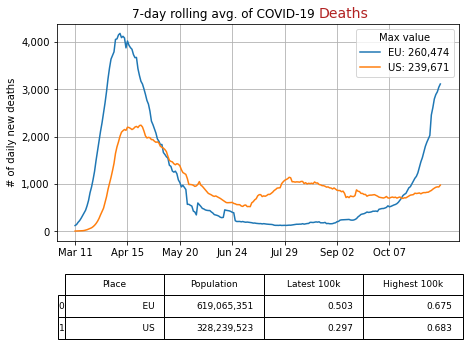

In [41]:
fig, ax = plt.subplots()
labels = []

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
# I borrowed the line above from https://preinventedwheel.com/matplotlib-thousands-separator-1-step-guide/

ref = plot_type()
print(ref)

xr = range(2 - ref,len(combined.columns)+1, 3)
xr = xr[:len(clist)]

for i in xr:
    plt.plot(mydays, combined.iloc[-len(mydays):,i])
    k = 1 if ref == 0 else 0
    lmax = round(combined.iloc[:,i-k-1].max())

    j = i if ref == 0 else i+2
    labels.append(combined.columns[j][6:] + ": " + "{:,}".format(lmax))

datelist = pd.date_range(start_date, periods=len(mydays)).tolist()
dlist = [d.strftime("%b %d") for d in datelist]
divx = len(mydays) // 7
ax.set_xticks(mydays[0::divx])
ax.set_xticklabels(dlist[0::divx])

#plt.xlabel("Date")
#plt.xlabel("Days since %s" %(datetime.datetime.strftime(start_date,'%B %d, %Y')))
#plt.ylabel('# of daily new %s' %('deaths' if a == 2 else 'cases'))

ylbl1 = ('# of daily new %s' % ('deaths' if a == 2 else 'cases'))
ylbl2 = ('# of cumulative %s' % ('deaths' if a == 2 else 'cases'))
plt.ylabel(ylbl1 if ref == 0 else ylbl2)

#title1 = ("7-day rolling avg. of COVID-19  %s" %('deaths' if a == 2 else 'cases'))
#title2 = ("Cumulative COVID-19  %s" %('deaths' if a == 2 else 'cases'))
##plt.title("7-day rolling avg. of COVID - %s" %('Deaths' if a == 2 else 'Cases'))
#plt.title(title1 if ref == 0 else title2)

title3 = '{:>30s}'.format("7-day rolling avg. of COVID-19 ")
title4 = '{:>20s}'.format("Cumulative COVID-19  ")
new_title = title3 if ref == 0 else title4
xpos = .30 if ref==0 else .43
plt.figtext(xpos, 0.90, new_title, fontsize='large', color='k', ha ='left')
plt.figtext(0.73, 0.90,'{:<s}'.format('Deaths' if a == 2 else 'Cases') ,fontsize=14, 
             color=('firebrick' if a==2 else 'teal'), ha='left')

# need to add code to indicate UK data excluded
if inpy == 110 or inpy == 78:
    plt.figtext(.425, 0.025, 'US cases don\'t include NY', style = 'italic', color = 'slateblue')
else:
    pass

plt.legend(labels, title = "Max value")
plt.grid()

mpl_table = plt.table(cellText = capita.values, rowLabels = capita.index, bbox = [.02, -.45, .99, .30], 
                      colLabels=capita.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(9)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.2, box.height])

plt.show
plt.savefig("plot_%s.png" %datetime.datetime.now().strftime("%m%d%Y_%H%M%S"), dpi = 600, bbox_inches = 'tight')

In [42]:
combined.to_csv(r'export_%s.csv' %datetime.datetime.now().strftime("%m%d%Y_%H%M%S"))

In [44]:
print(len(eulist),eulist)

37 ['Albania' 'Austria' 'Belgium' 'Bulgaria' 'Croatia' 'Cyprus'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Italy' 'Latvia' 'Liechtenstein'
 'Lithuania' 'Luxembourg' 'Macedonia' 'Malta' 'Montenegro' 'Netherlands'
 'Norway' 'Poland' 'Portugal' 'Romania' 'Serbia' 'Slovakia' 'Slovenia'
 'Spain' 'Sweden' 'Switzerland' 'Turkey' 'United Kingdom']


In [56]:
not_eulist = ['Albania','Montenegro','Serbia','Turkey']
in_eulist = eulist.tolist()
eulist = [item for item in eulist[0] if item not in not_eulist]

In [58]:
print(eulist, len(eulist))

['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macedonia', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom'] 33
